# Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from etna.datasets.tsdataset import TSDataset
from etna.models import NaiveModel
from etna.metrics import MAPE
from etna.metrics import SMAPE
from etna.analysis import plot_forecast
# from etna.models import ProphetModel
from etna.transforms import LagTransform
from etna.models import CatBoostMultiSegmentModel

In [2]:
df = pd.read_csv('data/prices_hist.csv')
df.head()

,datetime,price
0,2018-01-05,36550.0
1,2018-01-12,36850.0
2,2018-01-19,36850.0
3,2018-01-26,35200.0
4,2018-02-02,34650.0


In [3]:
df["timestamp"] = pd.to_datetime(df["datetime"])
df["target"] = df["price"]
df.drop(columns=["datetime", "price"], inplace=True)
df["segment"] = "main"
df.head()

,timestamp,target,segment
0,2018-01-05,36550.0,main
1,2018-01-12,36850.0,main
2,2018-01-19,36850.0,main
3,2018-01-26,35200.0,main
4,2018-02-02,34650.0,main


In [4]:
df = TSDataset.to_dataset(df)
df.head()

segment,main
feature,target
timestamp,
2018-01-05,36550.0
2018-01-12,36850.0
2018-01-19,36850.0
2018-01-26,35200.0
2018-02-02,34650.0


In [5]:
ts = TSDataset(df, freq="W-FRI")
ts.describe()

,start_timestamp,end_timestamp,length,num_missing,num_segments,num_exogs,num_regressors,num_known_future,freq
segments,,,,,,,,,
main,2018-01-05,2022-12-30,261,0,1,0,0,0,W-FRI


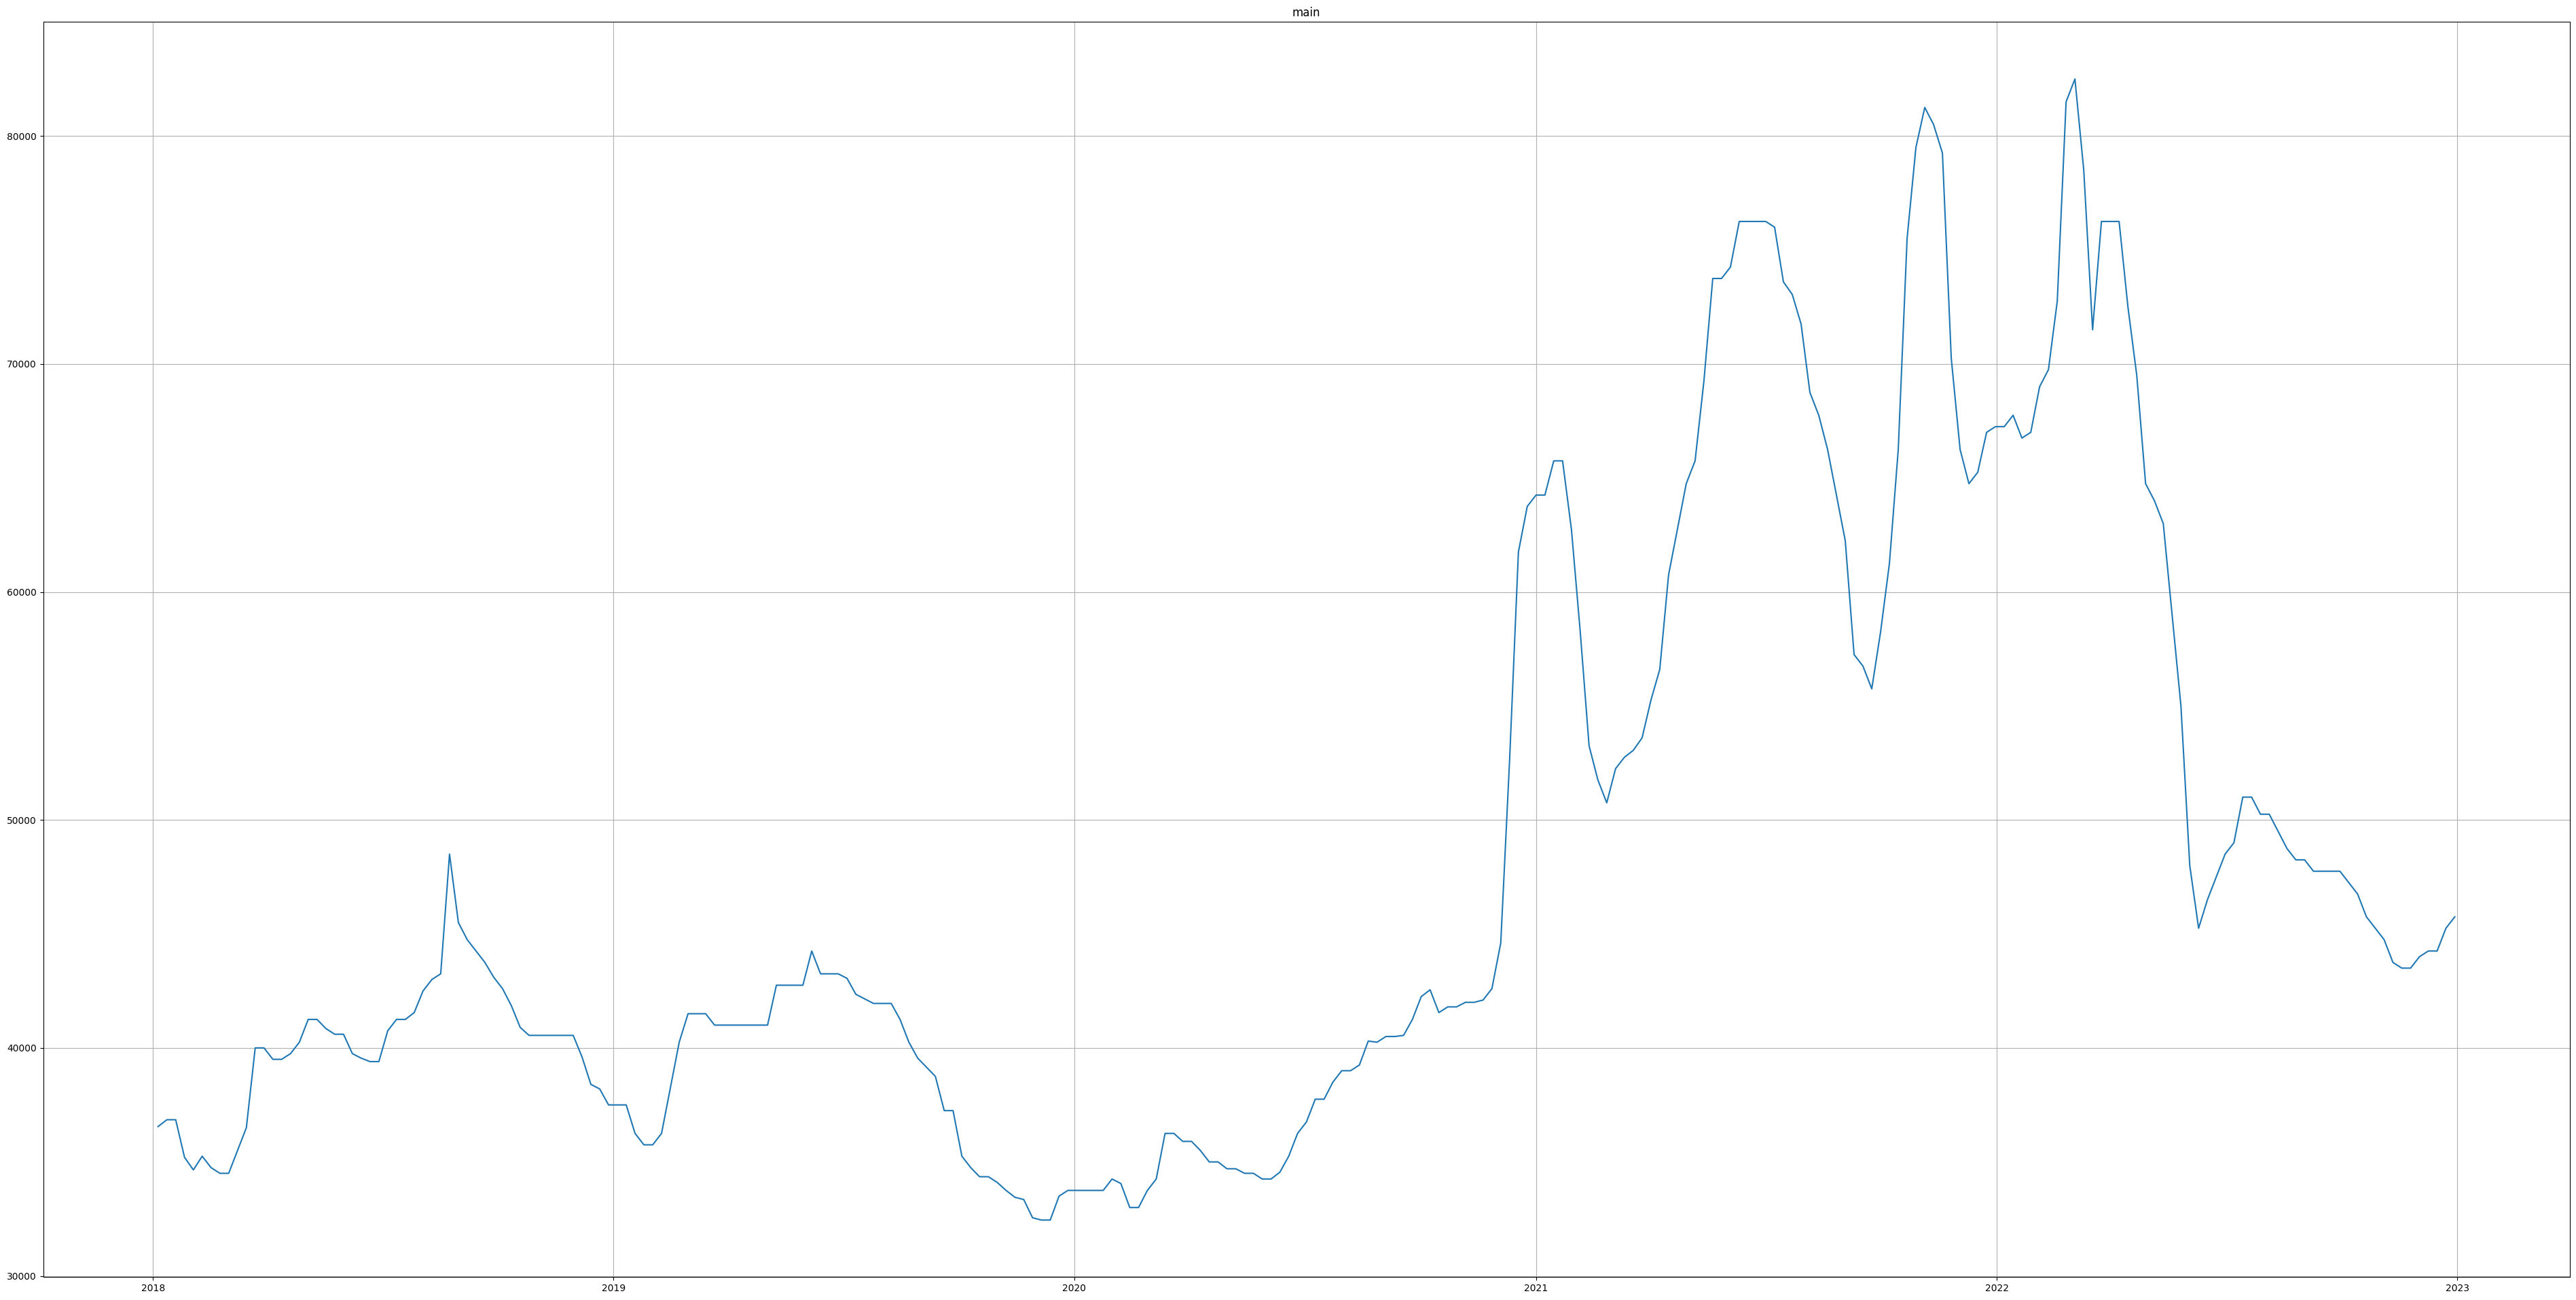

In [6]:
ts.plot(figsize=(48, 24))

# Catboost

BEST LAG LIST (который смог найти):


```
lags = LagTransform(in_column="target", lags=list(range(1, 94, 1)))
```

Погрешность MAPE и SMAPE ~1.6%
```
HORIZON = 26
mape = MAPE()
smape = SMAPE()
train_ts, test_ts = ts.train_test_split(
    train_start="2018-01-05",
    train_end="2022-06-30",
    test_start="2022-07-01",
    test_end="2022-12-23",
)
lags = LagTransform(in_column="target", lags=list(range(1, 94, 1)))
train_ts.fit_transform([lags])
model = CatBoostMultiSegmentModel()
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
train_ts.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=261)
print(mape(y_true=test_ts, y_pred=forecast_ts))
print(smape(y_true=test_ts, y_pred=forecast_ts))
```

{'main': 1.647716906133194}
{'main': 1.6356645839662867}


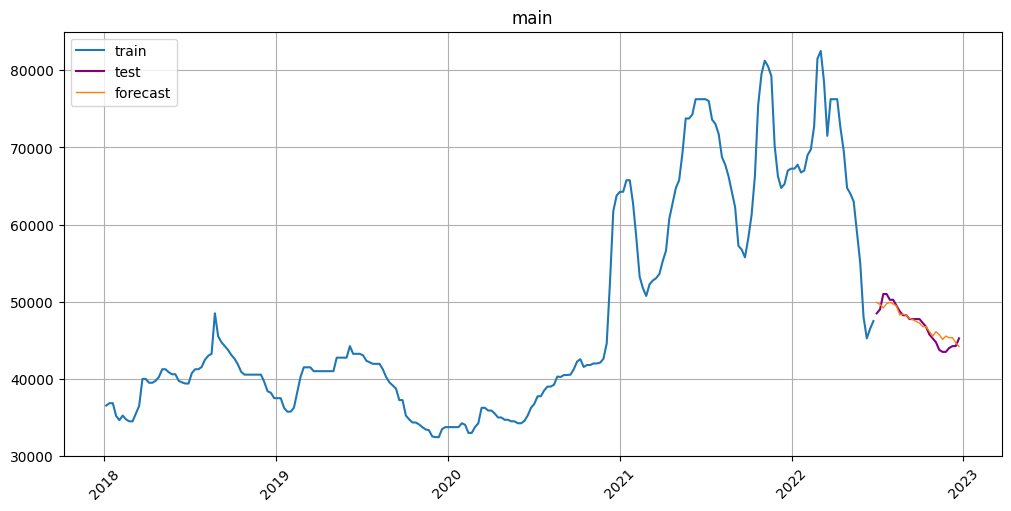

In [ ]:
HORIZON = 26
mape = MAPE()
smape = SMAPE()
train_ts, test_ts = ts.train_test_split(
    train_start="2018-01-05",
    train_end="2022-06-30",
    test_start="2022-07-01",
    test_end="2022-12-23",
)
lags = LagTransform(in_column="target", lags=list(range(1, 94, 1)))
train_ts.fit_transform([lags])
model = CatBoostMultiSegmentModel(task_type='CPU')
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
train_ts.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=261)
print(mape(y_true=test_ts, y_pred=forecast_ts))
print(smape(y_true=test_ts, y_pred=forecast_ts))

In [ ]:
import torch

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device:{torch.cuda.current_device()}")
		
print(f"Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")
print(f"How many devices {torch.cuda.device_count()}")

Is CUDA supported by this system?True
CUDA version: 11.7
ID of current CUDA device:0
Name of current CUDA device:NVIDIA GeForce RTX 2070 Super
How many devices 1


In [ ]:
history = {}
HORIZON = 26
mape = MAPE()
smape = SMAPE()
for n in range(1, 1001):
    train_ts, test_ts = ts.train_test_split(
        train_start="2018-01-05",
        train_end="2022-06-30",
        test_start="2022-07-01",
        test_end="2022-12-23",
    )
    lags = LagTransform(in_column="target", lags=list(range(1, 94, 1)))
    train_ts.fit_transform([lags])
    model = CatBoostMultiSegmentModel(iterations=n, depth=7, learning_rate=0.030001, l2_leaf_reg=2.001, task_type='GPU')
    model.fit(train_ts)
    future_ts = train_ts.make_future(HORIZON)
    forecast_ts = model.forecast(future_ts)
    train_ts.inverse_transform()
    history[n] = mape(test_ts, forecast_ts)
    # plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=261)
    print(n, ' | ', mape(y_true=test_ts, y_pred=forecast_ts))
    # print(smape(y_true=test_ts, y_pred=forecast_ts))

1  |  {'main': 12.988844224941637}
2  |  {'main': 12.181897228516593}
3  |  {'main': 12.181897228516593}
4  |  {'main': 12.154042261530721}
5  |  {'main': 12.154042261530721}
6  |  {'main': 11.761920767369556}
7  |  {'main': 11.688492021365457}
8  |  {'main': 10.981620287454279}
9  |  {'main': 10.539349006664095}
10  |  {'main': 10.044112112475336}
11  |  {'main': 10.016379608720529}
12  |  {'main': 9.191959553119458}
13  |  {'main': 9.103923131657355}
14  |  {'main': 8.936288012530257}
15  |  {'main': 8.866239782754121}
16  |  {'main': 8.33419851175421}
17  |  {'main': 8.07686901959673}
18  |  {'main': 7.528415528657514}
19  |  {'main': 6.878955915758478}
20  |  {'main': 6.500676709409399}
21  |  {'main': 6.4933466471870815}
22  |  {'main': 6.036540820237456}
23  |  {'main': 5.666184140668296}
24  |  {'main': 5.6698085867899835}
25  |  {'main': 5.341234719607518}
26  |  {'main': 5.127314492207113}
27  |  {'main': 4.815251998729616}
28  |  {'main': 4.5743521817960975}
29  |  {'main': 4

In [ ]:
print(min(history, key = lambda k: history[k]['main']))

636


In [ ]:
history[636]

{'main': 2.6082541568257107}

In [ ]:
min = 1.2979163975864187
smin = 1.2944845221632706
best = 593
sbest = 593
for i in range(593, 1100):
  HORIZON = 26
  mape = MAPE()
  smape = SMAPE()
  train_ts, test_ts = ts.train_test_split(
      train_start="2018-01-05",
      train_end="2022-06-30",
      test_start="2022-07-01",
      test_end="2022-12-23",
  )
  lags = LagTransform(in_column="target", lags=list(range(1, 94, 1)))
  train_ts.fit_transform([lags])
  model = CatBoostMultiSegmentModel(iterations=i, depth=6, learning_rate=0.0300007, l2_leaf_reg=2.001)
  model.fit(train_ts)
  future_ts = train_ts.make_future(HORIZON)
  forecast_ts = model.forecast(future_ts)
  train_ts.inverse_transform()
  #plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=261)
  print("\n=================\n")
  print("Iterations =", i)
  print(mape(y_true=test_ts, y_pred=forecast_ts))
  print(smape(y_true=test_ts, y_pred=forecast_ts))
  if mape(y_true=test_ts, y_pred=forecast_ts)['main'] < min:
    min = mape(y_true=test_ts, y_pred=forecast_ts)['main']
    best = i
  if smape(y_true=test_ts, y_pred=forecast_ts)['main'] < smin:
    smin = smape(y_true=test_ts, y_pred=forecast_ts)['main']
    sbest = i
  print("Current best MAPE:", best, "with", min)
  print("Current best SMAPE:", sbest, "with", smin)

In [ ]:
history = {}
HORIZON = 26
mape = MAPE()
smape = SMAPE()
for n in range(2, 234):
    train_ts, test_ts = ts.train_test_split(
        train_start="2018-01-05",
        train_end="2022-06-30",
        test_start="2022-07-01",
        test_end="2022-12-23",
    )
    lags = LagTransform(in_column="target", lags=list(range(1, n, 1)))
    train_ts.fit_transform([lags])
    model = CatBoostMultiSegmentModel(depth=7, l2_leaf_reg=2.001, task_type='GPU')
    model.fit(train_ts)
    future_ts = train_ts.make_future(HORIZON)
    forecast_ts = model.forecast(future_ts)
    train_ts.inverse_transform()
    history[n] = mape(test_ts, forecast_ts)
    # plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=261)
    print(n, ' | ', mape(y_true=test_ts, y_pred=forecast_ts))
    # print(smape(y_true=test_ts, y_pred=forecast_ts))

2  |  {'main': 28.86849700151302}
3  |  {'main': 27.779072539183037}
4  |  {'main': 26.50987823554205}
5  |  {'main': 26.203886532300018}
6  |  {'main': 25.413848920412978}
7  |  {'main': 25.119469236490303}
8  |  {'main': 24.81047533632702}
9  |  {'main': 23.87405678459841}
10  |  {'main': 23.99550713919811}
11  |  {'main': 24.42257588975563}
12  |  {'main': 23.716483222554423}
13  |  {'main': 23.66837443808793}
14  |  {'main': 23.75936867195524}
15  |  {'main': 22.473004996144812}
16  |  {'main': 22.68085083193407}
17  |  {'main': 20.689590736561033}
18  |  {'main': 22.211694962915878}
19  |  {'main': 21.06487129301911}
20  |  {'main': 21.933102960940985}
21  |  {'main': 20.11971770359094}
22  |  {'main': 20.653770673303576}
23  |  {'main': 21.124701746162355}
24  |  {'main': 19.633718636548146}
25  |  {'main': 18.088621386042743}
26  |  {'main': 18.771144388317353}
27  |  {'main': 16.885672039906055}
28  |  {'main': 19.07959437644507}
29  |  {'main': 19.97011428954958}
30  |  {'main

CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/cuda/methods/dynamic_boosting.h:198: Error: pool has just 3 groups or docs, can't use #1 GPUs to learn on such small pool

{'main': 1.2942565860067858}
{'main': 1.2892124811562573}


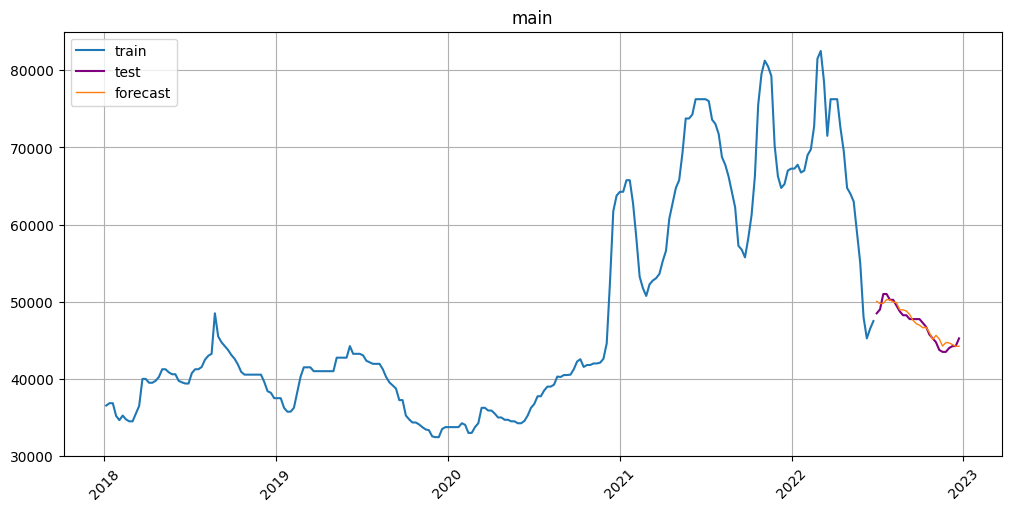

In [ ]:
HORIZON = 26
mape = MAPE()
smape = SMAPE()
train_ts, test_ts = ts.train_test_split(
    train_start="2018-01-05",
    train_end="2022-06-30",
    test_start="2022-07-01",
    test_end="2022-12-23",
)
lags = LagTransform(in_column="target", lags=list(range(1, 94, 1)))
train_ts.fit_transform([lags])
# iterations=1004, depth=6, learning_rate=0.0300007, l2_leaf_reg=2.001,
# depth=6, learning_rate=0.0300007, l2_leaf_reg=2.001, bootstrap_type='MVS', task_type='CPU' 1.28
model = CatBoostMultiSegmentModel(depth=6, learning_rate=0.0300007, l2_leaf_reg=2.001, bootstrap_type='MVS', task_type='CPU')
model.fit(train_ts)
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model.forecast(future_ts)
train_ts.inverse_transform()
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=261)
print(mape(y_true=test_ts, y_pred=forecast_ts))
print(smape(y_true=test_ts, y_pred=forecast_ts))

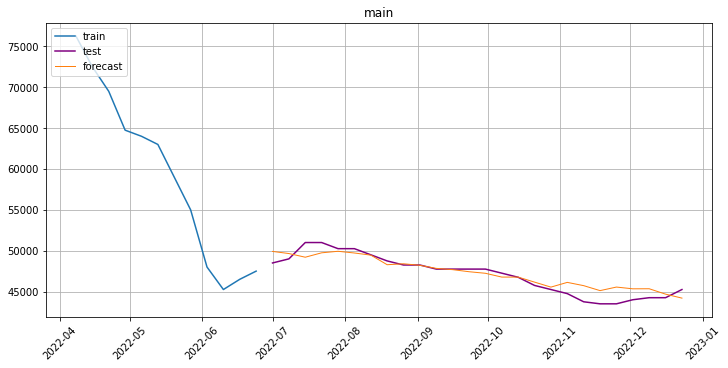

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=12)